In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

## 1. Обработка и разведочный анализ данных

In [59]:
# Чтение файла с реестром займов в датафрейм
df = pd.read_csv('../data/loans.csv', sep=';')
df.columns = list(map(str.lower, df.columns.values))

# Изменение типа данных столбца TREAT_DATE с object на datetime
df['treat_date'] = pd.to_datetime(df['treat_date'], dayfirst=True)
df.head()

,demand,treat_date,treatment_flag
0,36026098,2023-10-25,1
1,36073351,2023-10-25,1
2,37540360,2023-10-25,1
3,37540643,2023-10-25,0
4,37621229,2023-10-25,0


In [60]:
# Проверка наличия дубликатов:

print('Кол-во дубликатов по полю demand:',\
    len(df[df.duplicated(['demand'])]), '- id займа не уникальны, так как взаимодействия осуществлялись в разные дни.')

print('Кол-во дубликатов по полям demand, treat_date:',\
    len(df[df.duplicated(['demand', 'treat_date'])])) 

Кол-во дубликатов по полю demand: 23734 - id займа не уникальны, так как взаимодействия осуществлялись в разные дни.
Кол-во дубликатов по полям demand, treat_date: 0


In [51]:
# Определение дат взаимодействия:
df['treat_date'].value_counts().sort_values() # взаимодействия осуществлялись 25 октября и 30 октября 2023 года

treat_date
2023-10-25    30105
2023-10-30    31924
Name: count, dtype: int64

#### <span style="color:rgb(100, 24, 63);">Таким образом, мы видим, что A/B-тест проводился в течение двух дней - 25 октября и 30 октября 2023 года. В тесте от 25 октября участвовало 30105 займов, а в тесте от 30 октября - 31924 займа.</span>   
#### _Определим, есть ли займы, участвовавшие в A/B-тесте в оба дня._

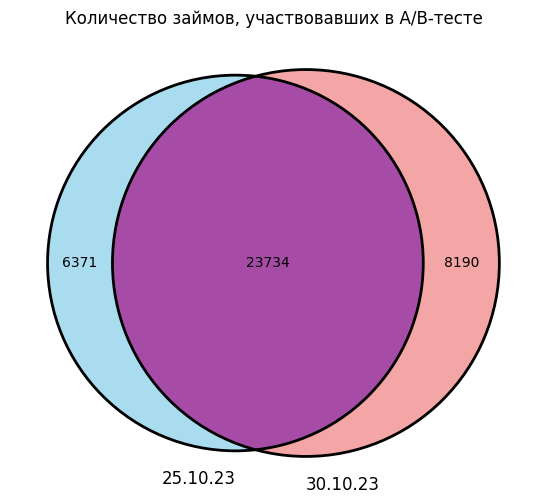

In [52]:
set25 = set(df[df['treat_date'] == '2023-10-25'].demand)
set30 = set(df[df['treat_date'] == '2023-10-30'].demand)

plt.figure(figsize=(8, 6))

venn = venn2(
    [set25, set30], 
    set_labels=('25.10.23', '30.10.23'),
    set_colors=('skyblue', 'lightcoral'),
    alpha=0.7
)

venn.get_patch_by_id('11').set_color('purple')
venn.get_patch_by_id('11').set_alpha(0.7)

venn2_circles(
    [set25, set30], 
    linestyle='-', 
    linewidth=2, 
    color='black'
)

plt.title("Количество займов, участвовавших в A/B-тесте")
plt.grid(False)
plt.show()

#### Как видно из диаграммы выше, бОльшая часть займов участвовала в A/B-тесте в оба дня. Займы, которые участвовали только в одном тесте, составляют 21% и 26% от объема выборок для 25.10 и 30.10 соответственно.   
#### _Определим имеющиеся комбинации флагов взаимодействия 25.10 и 30.10 в структуре займов, участвовавших в тесте два раза. Для этого построим матрицу сопряженности._

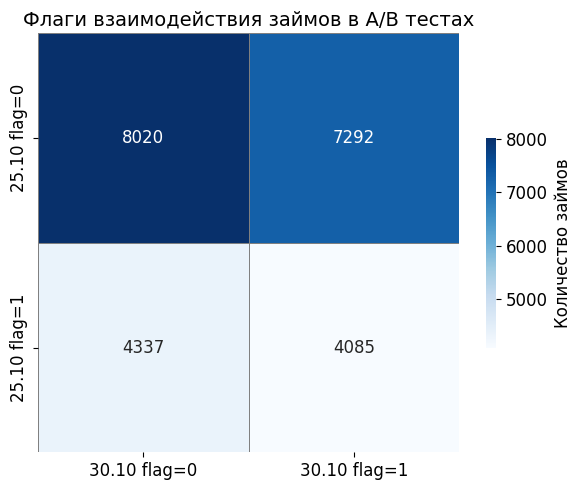

In [53]:
df25 = df[df['treat_date'] == pd.to_datetime('2023-10-25')]
df30 = df[df['treat_date'] == pd.to_datetime('2023-10-30')]

df_intersect = df25.merge(df30, on='demand', how='inner', suffixes=('_2510', '_3010'))
df_conti = df_intersect[['demand', 'treatment_flag_2510', 'treatment_flag_3010']]

contingency_table = pd.crosstab(
    df_intersect['treatment_flag_2510'], 
    df_intersect['treatment_flag_3010']
)

contingency_table.index = ['25.10 flag=0', '25.10 flag=1']
contingency_table.columns = ['30.10 flag=0', '30.10 flag=1']

plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(contingency_table, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'shrink': 0.5},
            linewidths=0.5,
            linecolor='gray',
            annot_kws={'size': 12})

cbar = heatmap.collections[0].colorbar
cbar.set_label('Количество займов', size=12)
cbar.ax.tick_params(labelsize=12)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)

plt.title('Флаги взаимодействия займов в A/B тестах', fontsize=14, loc='center')
plt.tight_layout()
plt.show()

#### Как видно из матрицы сопряженности, среди рассматриваемых займов имеются все возможные комбинации флагов взаимодействия.  В эксперименте от 25.10 присутствовала не только контрольная группа (8020 + 7292 наблюдения), но также и тестовая (4337 + 4085 наблюдений). Следовательно, эксперимент от 25.10 нельзя назвать чистым претестом.
#### Таким образом, имеем проблему пересечения выборок. В нашем распоряжении находятся займы, имеющие разные истории воздействия:
- 1 группа: контроль 25.10 и контроль 30.10 (8020 займов);
- 2 группа: контроль 25.10 и тест 30.10 (7292 займа);  
- 3 группа: тест 25.10 и контроль 30.10 (4337 займов);
- 4 группа: тест 25.10 и тест 30.10 (4085 займов).
#### Несмотря на то, что по условию бизнес-логики платежи учитываются в течение 3 дней после взаимодействия, а между первым и вторым днем теста разница 5 дней, включение групп 3 и 4 в оценку результата A/B-теста может исказить ее результат, так как факт свершившегося целевого взаимодействия 25 октября мог оказать влияние на поведение заемщика 30 октября, то есть, в данном случае может иметь место эффект интерференции.
#### Методологически чистым и более простым для интерпретации будет анализ только "чистых" клиентов 30 октября. К тому же, оценка теста на данных группах позволяет использовать данные от 25.10 как ковариату для метода CUPED, что, при условии наличия корреляции между целевым признаком и ковариатой позволит повысить чувствительность эксперимента и получить достоверные результаты быстрее. В данном случае мы проанализируем только 25% от всех имеющихся займов, и есть риск, что такого количества (15 312 шт.) будет недостаточно для обнаружения разумных эффектов. 
#### Что касается займов, участвовавших только в одном тесте, можно проверить, не отличаются ли они систематически от займов, участвовавших в обоих тестах.


In [54]:
# Оставляем только "чистых" клиентов 30 октября

df = df_intersect[df_intersect['treatment_flag_2510'] == 0]\
    .drop(columns=['treatment_flag_2510'])\
    .rename(columns={
        'treat_date_2510': 'treat_date_pre',
        'treat_date_3010': 'treat_date_post',
        'treatment_flag_3010': 'treatment_flag'
    })

In [55]:
# Чтение файла со сведениями о платежах в датафрейм
df2 = pd.read_csv('../data/payments.csv', sep=';')
df2.columns = list(map(str.lower, df2.columns.values))

# Изменение типа данных столбца PAY_STAMP с object на datetime
df2['pay_stamp'] = pd.to_datetime(df2['pay_stamp'], dayfirst=True)
df2.head()

,payment_id,pay_stamp,demand
0,13987558,2023-10-18 17:12:00,35072400
1,14017760,2023-10-20 09:02:00,36764746
2,14025848,2023-10-20 19:07:00,37389598
3,14034783,2023-10-21 19:03:00,37712341
4,14086482,2023-10-25 07:03:00,37549942


In [56]:
# Проверка наличия дубликатов:

print('Кол-во дубликатов по полю payment_id:',\
      len(df2[df2.duplicated(['payment_id'])]), '- id платежей уникальны.')

print('Кол-во дубликатов по полю demand:',\
      len(df2[df2.duplicated(['demand'])]), '- по одному займу может быть несколько разных платежей.')

Кол-во дубликатов по полю payment_id: 0 - id платежей уникальны.
Кол-во дубликатов по полю demand: 1287 - по одному займу может быть несколько разных платежей.


In [10]:
# Формируем итоговый датафрейм с информацией о платежах по займам в тесте и претесте

df_itog = df.copy()

suffixes = ['pre', 'post']

for suff in suffixes:

    # Объединяем данные
    total_df = df.merge(df2, how='left', on='demand')

    # Рассчитываем разницу в днях для платежей
    total_df[f'delta_days_{suff}'] = (total_df['pay_stamp'] - total_df[f'treat_date_{suff}']).dt.days

    # Определяем, какие платежи попадают в 3-дневное окно
    total_df['payment_in_window'] = ((total_df[f'delta_days_{suff}'] >= 0) &
                                    (total_df[f'delta_days_{suff}'] <= 3)).astype(int)
    print(total_df[(total_df[f'delta_days_{suff}'] >= 0) &
                (total_df[f'delta_days_{suff}'] <= 3)][f'delta_days_{suff}'].value_counts().sort_index())


    # Группируем по займам для подсчета платежей в окне, создаем флаг платежа
    payments_count = total_df.groupby('demand', as_index=False)['payment_in_window'].sum()
    payments_count.rename(columns={'payment_in_window': f'payments_amount_{suff}'}, inplace=True)
    payments_count[f'payment_flag_{suff}'] = (payments_count[f'payments_amount_{suff}'] > 0).astype(int)

    # Объединяем с исходным датафреймом
    df_itog = df_itog.merge(payments_count, how='left', on='demand')

delta_days_pre
0.0    193
1.0     73
2.0     42
3.0     15
Name: count, dtype: int64
delta_days_post
0.0    147
1.0    220
2.0    170
3.0    123
Name: count, dtype: int64


#### Таким образом, мы видим, что в претесте по займам поступило меньше платежей, чем в тесте. В претесте по займам, по которым поступал хотя бы один платёж, больше всего платежей поступало в день взаимодействия, а в тесте - на следующий день после взаимодействия.

## 2. Расчет описательных статистик и проведение статистических тестов

#### _Определим среднее количество платежей на займ и долю займов с оплатой (конверсию) в разбивке по группам для теста и претеста:_

In [11]:
stat_pre = df_itog.pivot_table(
    index=['treatment_flag'],
    aggfunc={'payments_amount_pre': ['count', 'mean'], 'payment_flag_pre': 'mean'},
    sort=False
)

stat_pre.columns = pd.MultiIndex.from_product([['pretest'], ['n_obs', 'avg_pays_count', 'pays_share']])

stat_post = df_itog.pivot_table(
    index=['treatment_flag'],
    aggfunc={'payments_amount_post': 'mean', 'payment_flag_post': 'mean'},
    sort=False
)

stat_post.columns = pd.MultiIndex.from_product([['test'], ['avg_pays_count', 'pays_share']])

combined = pd.concat([stat_pre, stat_post], axis=1)
float_columns = [
    ('pretest', 'avg_pays_count'),
    ('pretest', 'pays_share'),
    ('test', 'avg_pays_count'),
    ('test', 'pays_share')
]
combined[float_columns] = combined[float_columns].round(3)
combined

pretest                                     test           
                 n_obs avg_pays_count pays_share avg_pays_count pays_share
treatment_flag                                                            
0                 8020          0.022      0.020          0.039      0.037
1                 7292          0.020      0.019          0.047      0.043

#### Как мы видим, и в тесте, и в претесте значения среднего количества платежей практически не отличаются от значений конверсии в оплату. Это значит, что по большинству займов вообще не поступало платежей. Конверсии в оплату в претесте примерно равны (около 2%) и меньше, чем в тесте как для контрольной, так и для тестовой группы. В тесте конверсия в оплату в тестовой группе выше, чем в контрольной - 4.3% против 3.7%, т.е., _lift_ = +0.6 п.п.

#### _Рассмотрим распределения количества платежей:_

In [12]:
pays_post = df_itog.pivot_table(
    index=['payments_amount_post'],
    columns=['treatment_flag'],
    values=['demand'],
    aggfunc=len
)
pays_post.columns = pd.MultiIndex.from_product([['test'], pays_post.columns.get_level_values(1)])

pays_pre = df_itog.pivot_table(
    index=['payments_amount_pre'],
    columns=['treatment_flag'],
    values=['demand'],
    aggfunc=len
)
pays_pre.columns = pd.MultiIndex.from_product([['pretest'], pays_pre.columns.get_level_values(1)])

combined = pd.concat([pays_pre, pays_post], axis=1).fillna(0).astype('Int64')
combined.index.name = 'payment_amount'
combined

pretest        test      
treatment_flag       0     1     0     1
payment_amount                          
0                 7858  7154  7725  6978
1                  148   133   281   294
2                   12     4    10    12
3                    1     1     2     5
4                    1     0     2     3

#### Во всех группах по большинству займов в период 3-дневного закрепления не поступило не одного платежа.

#### _Рассмотрим доли оплаченных и неоплаченных займов по группам в A/B-тесте:_

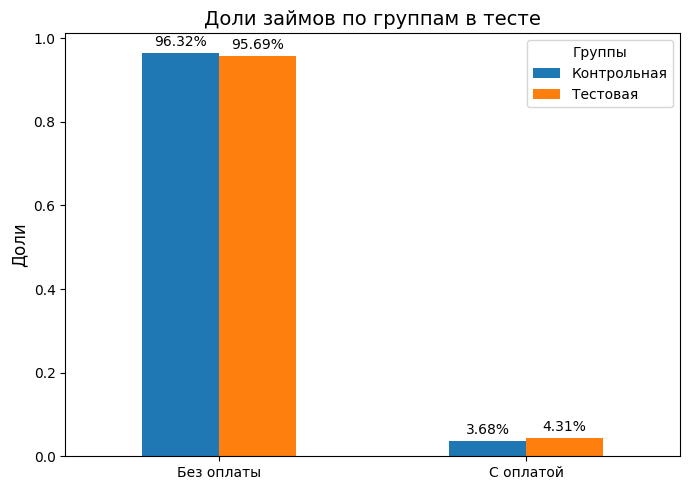

In [13]:
control_data_p = df_itog[df_itog['treatment_flag'] == 0].payment_flag_pre
test_data_p = df_itog[df_itog['treatment_flag'] == 1].payment_flag_pre

control_data_t = df_itog[df_itog['treatment_flag'] == 0].payment_flag_post
test_data_t = df_itog[df_itog['treatment_flag'] == 1].payment_flag_post

data_to_plot = pd.DataFrame({
    'Контрольная': [1 - control_data_t.mean(), control_data_t.mean()],
    'Тестовая': [1 - test_data_t.mean(), test_data_t.mean()]
}, index=['Без оплаты', 'С оплатой'])

fig, ax = plt.subplots(figsize=(7, 5))
bars = data_to_plot.plot(kind='bar', ax=ax)

for container in ax.containers:
    ax.bar_label(container, 
                 labels=[f'{val:.2%}' for val in container.datavalues],
                 padding=3,
                 fontsize=10)

plt.title('Доли займов по группам в тесте', fontsize=14)
plt.ylabel('Доли', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Группы')
plt.tight_layout()
plt.show()

#### В тесте имеем превышение конверсии в оплату в тестовой группе над контрольной:  
- **_Uplift_** = +0.63 п.п.  
- **_Lift_** = +17.1%

#### <span style="color:rgb(100, 24, 63);">Как видно из расчета среднего количества платежей, данная метрика не является информативной, так по абсолютному большинству займов как в контрольной, так и в тестовой группе, платежей после взаимодействия не поступало. Поэтому выборки для анализа сформируем из категориального __бинарного__ признака - __флага платежа__, а в качестве ключевых метрик возьмем __выборочные доли "успехов"__ (конверсии в платеж) для контрольной и тестовой группы соответственно.</span> 
 
#### <span style="color:rgb(100, 24, 63);">Основным методом анализа в такой ситуации (большой объем выборки, когда биномиальное распределение приближается к нормальному) является __Z-test для двух пропорций__, проверяющий гипотезу о том, является ли статистически значимым различие в двух долях. Так как конверсия в оплату в тестовой группе оказалась несколько больше, чем в контрольной, есть основание предполагать, что запущенная в A/B-тесте фича привнесла __положительный__ эффект, поэтому проведем Z-тест с правосторонней альтернативой.</span>

#### _1. Вычислим выборочные доли как точечные несмещенные оценки "успеха" в биномиальном распределении, а также определим для них 95%-е доверительные интервалы_

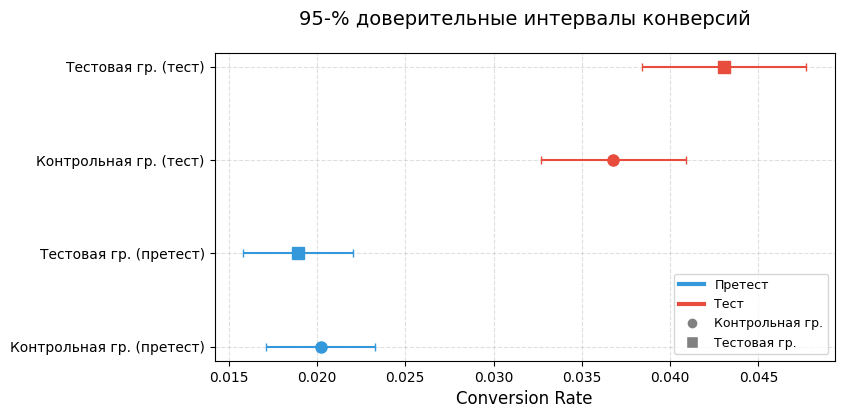

In [14]:
data = [
    (control_data_p, 'Контрольная гр. (претест)'),
    (test_data_p, 'Тестовая гр. (претест)'),
    (control_data_t, 'Контрольная гр. (тест)'),
    (test_data_t, 'Тестовая гр. (тест)')
]

conf_ints = []
for dat, name in data:
    _, upper = proportion_confint(count=dat.sum(), nobs=dat.count(), alpha=0.05, method='normal')
    conf_ints.append({'kind': name, 'mean': dat.mean(), 'right': upper})

df = pd.DataFrame(conf_ints)
fig, ax = plt.subplots(figsize=(8, 4))

colors = {'pre': '#3498db', 'test': '#e74c3c'}
markers = {'control': 'o', 'test': 's'}

for i, row in df.iterrows():
    kind = row['kind']
    color = colors['pre'] if '(претест)' in kind else colors['test']
    marker = markers['control'] if 'Контрольная' in kind else markers['test']

    ax.errorbar(x=row['mean'], y=i, 
                xerr=row['right'] - row['mean'], 
                fmt=marker, color=color, 
                capsize=3, markersize=8)

ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['kind'])
ax.set_xlabel('Conversion Rate', fontsize=12)
ax.set_title('95-% доверительные интервалы конверсий', fontsize=14, pad=20)
ax.grid(True, alpha=0.4, linestyle='--')

legend_elements = [
    Line2D([0], [0], color=colors['pre'], lw=3, label='Претест'),
    Line2D([0], [0], color=colors['test'], lw=3, label='Тест'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='Контрольная гр.'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markersize=8, label='Тестовая гр.')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
plt.show()

#### Доверительные интервалы для конверсий в претесте практически полностью совпадают. В тесте доверительный интервал для конверсии из тестовой группы имеет небольшое пересечение слева с интервалом для конверсии из контрольной группы.

#### _2. Проверим гипотезу о равенстве пропорций. Альтернативная гипотеза будет заключаться в том, что значение выборочной доли для тестовой группы будет статистически значимо превышать значение доли для контрольной группы (в тесте). Таким образом, проведем Z-test с правосторонней альтернативой._

In [15]:
# для теста (правосторонняя альтернатива)

z_stat, p_value = proportions_ztest(
    count=[test_data_t.sum(), control_data_t.sum()],
    nobs=[test_data_t.count(), control_data_t.count()],
    alternative='larger'
)

z_stat, p_value

(np.float64(1.9852971755887154), np.float64(0.023555709050193132))

#### **Для теста:** p_value < alpha (0.02 < 0.05), т.е. нулевая гипотеза о равенстве долей отвергается, различие между конверсиями в контрольной и тестовой группах не случайно (конверсия в тестовой группе выше, чем в контрольной). 

In [16]:
# для претеста (двусторонняя альтернатива)

z_stat, p_value = proportions_ztest(
    count=[test_data_p.sum(), control_data_p.sum()],
    nobs=[test_data_p.count(), control_data_p.count()],
    alternative='two-sided'
)

z_stat, p_value

(np.float64(-0.5683792753071358), np.float64(0.5697774598169304))

#### **Для претеста:** p_value > alpha (0.57 < 0.05), т.е. нулевая гипотеза о равенстве долей не отвергается, конверсии равны. Это ожидаемый результат, так как в претесте все займы "из контроля", т.е. по ним не было целевого взаимодействия.

#### _3. Убедимся в том, что в наших выборках нет "проблем" и данный критерий для них вообще можно применять. Для этого проведем A/A и B/B тесты на исходных выборках, а также с помощью метода Монте-Карло, многократно (1000 раз) семплируя выборки и проводя z-тест на равенство пропорций._

In [17]:
# A/A и B/B тесты на исходных выборках
 
for sample, name in data:
    _, p_value = proportions_ztest(
        count=[sample.sum(), sample.sum()],
        nobs=[sample.count(), sample.count()],
        alternative='larger'
    )

    print(f'{name}: p_value = {p_value:.3f}')

Контрольная гр. (претест): p_value = 0.500
Тестовая гр. (претест): p_value = 0.500
Контрольная гр. (тест): p_value = 0.500
Тестовая гр. (тест): p_value = 0.500


#### Как для А/А, так и для B/B тестов p-value > 0.05, гипотезы о равенстве долей уверенно не отвергаются при данном уровне значимости. Для большей уверенности в том, что наш критерий отличает одну и ту же группу от самой себя не лучше, чем случайное угадывание, проведем имитации Монте-Карло.

In [18]:
# Метод Монте-Карло

N = 1000

# A/A тесты (тест)
pvalues = []
for dat in data[2: ]:
    smpl = dat[0]
    for _ in range(N):
        smpl1 = smpl.sample(len(smpl), replace=True)
        smpl2 = smpl.sample(len(smpl), replace=True)
        res = proportions_ztest(
            count=[smpl1.sum(), smpl2.sum()],
            nobs=[smpl1.count(), smpl2.count()],
            alternative='larger'
        )
        pvalues.append(res[1])

pvalues_aa_t, pvalues_bb_t = pvalues[: N], pvalues[N: ]

# A/A тесты (претест)
pvalues = []
for dat in data[: 2]:
    smpl = dat[0]
    for _ in range(N):
        smpl1 = smpl.sample(len(smpl), replace=True)
        smpl2 = smpl.sample(len(smpl), replace=True)
        res = proportions_ztest(
            count=[smpl1.sum(), smpl2.sum()],
            nobs=[smpl1.count(), smpl2.count()],
            alternative='larger'
        )
        pvalues.append(res[1])

pvalues_aa_p, pvalues_bb_p = pvalues[: N], pvalues[N: ]

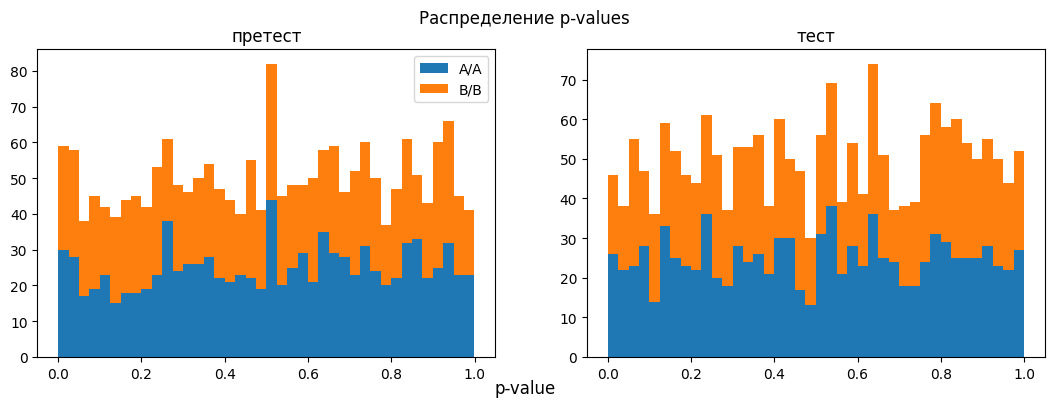

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].hist([pvalues_aa_p, pvalues_bb_p], bins=40, stacked=True, label=['A/A', 'B/B'])
ax[0].set_title('претест')
ax[0].legend(loc='upper right', bbox_to_anchor=(1, 1))

ax[1].hist([pvalues_aa_t, pvalues_bb_t], bins=40, stacked=True, label=['A/A', 'B/B'])
ax[1].set_title('тест')

fig.supxlabel('p-value')
fig.suptitle('Распределение p-values', fontsize=12)
plt.show()

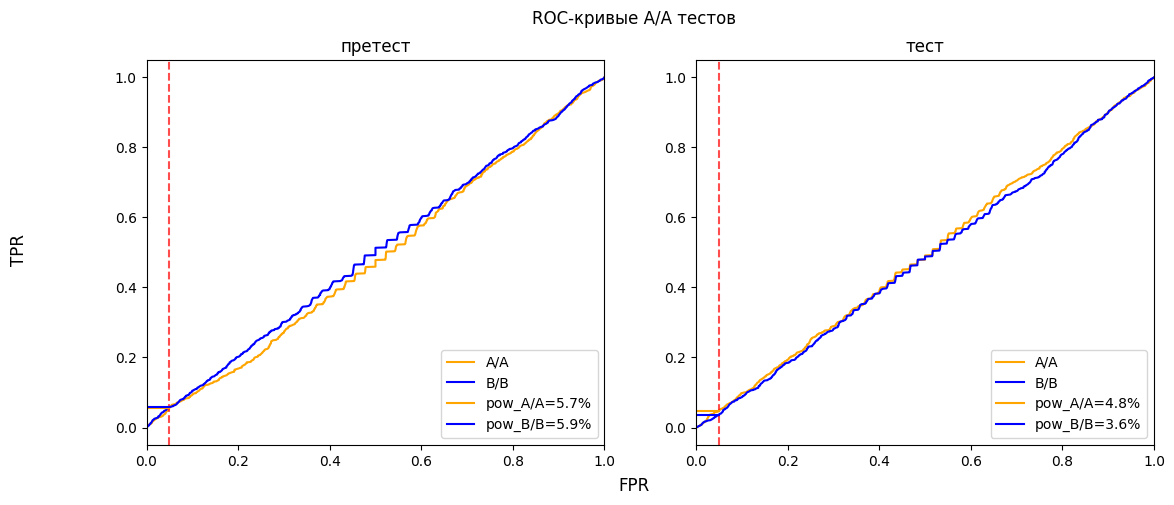

In [20]:
alpha = 0.05
power_aa_p = np.mean(np.array(pvalues_aa_p) < alpha)
power_bb_p = np.mean(np.array(pvalues_bb_p) < alpha)
power_aa_t = np.mean(np.array(pvalues_aa_t) < alpha)
power_bb_t = np.mean(np.array(pvalues_bb_t) < alpha)

data = [
    [(pvalues_aa_p, pvalues_bb_p), (power_aa_p, power_bb_p), 'претест'],
    [(pvalues_aa_t, pvalues_bb_t), (power_aa_t, power_bb_t), 'тест']
]

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
for i, (pval, pow, name) in enumerate(data):
    ax[i].plot(np.sort(pval[0]), [i / N for i in range(N)], color='orange', label='A/A')
    ax[i].plot(np.sort(pval[1]), [i / N for i in range(N)], color='blue', label='B/B')
    ax[i].axvline(x=alpha, color='r', linestyle='--', alpha=0.7)
    ax[i].plot([0, alpha], [pow[0], pow[0]], color='orange', label=f'pow_A/A={pow[0] * 100:.1f}%')
    ax[i].plot([0, alpha], [pow[1], pow[1]], color='blue', label=f'pow_B/B={pow[1] * 100:.1f}%')
    ax[i].legend(loc='lower right')
    ax[i].set_xlim(0, 1)
    ax[i].set_title(f'{name}')

fig.supxlabel('FPR', fontsize=12)
fig.supylabel('TPR', fontsize=12)
fig.suptitle(f'ROC-кривые A/A тестов', fontsize=12)
plt.show()

#### Как видно из полученных гистограмм распределения и ROC-кривых, для всех тестов распределение p-value походит на равномерное. Это означает, что вероятности получения того или иного p-value в тестах примерно одинаковые. Следовательно, вероятность получения ложноположительного результата при отстутствии реальных различий возникает только по случайности с заданной вероятностью alpha = 0.05. Таким образом, можно сделать вывод о том, что критерий значимости откалиброван верно.

#### _4. Проведем теперь пост-оценку мощности теста, чтобы определить, как часто мы будем верно отвергать нулевую гипотезу. Для этого также проведем эксперимент методом Монте-Карло, многократно семплируя выборки и проводя z-test на равенство пропорций._

In [21]:
# Метод Монте-Карло
# A/B-тест

pvalues = []
data = [(test_data_p, control_data_p, 'two-sided'), (test_data_t, control_data_t, 'larger')]

for dat in data:
    test_smpl, control_smpl, alt = dat
    for _ in range(N):
        test = test_smpl.sample(len(test_smpl), replace=True)
        control = control_smpl.sample(len(control_smpl), replace=True)
        res = proportions_ztest(
            count=[test.sum(), control.sum()],
            nobs=[test.count(), control.count()],
            alternative=alt
        )
        pvalues.append(res[1])

pvalues_ab_p, pvalues_ab_t = pvalues[: N], pvalues[N: ]

#### Построим гистограмму распределения полученных в результате эксперимента p-value.

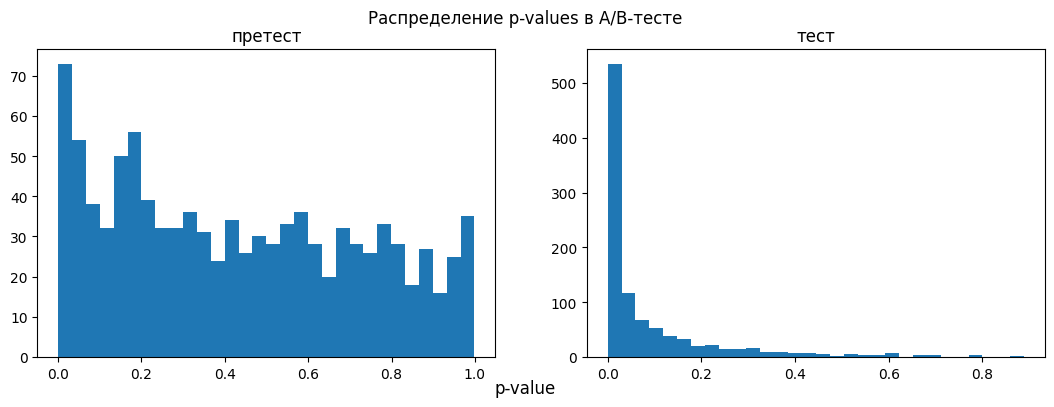

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].hist(pvalues_ab_p, bins=30)
ax[0].set_title('претест')

ax[1].hist(pvalues_ab_t, bins=30)
ax[1].set_title('тест')

fig.supxlabel('p-value')
fig.suptitle('Распределение p-values в А/B-тесте', fontsize=12)
plt.show()

#### Распределение p-value в тесте отлично от равномерного, основная масса наблюдений сконцентрирована возле нуля. Определим долю экспериментов, в которой полученные p-value оказались ниже порога значимости и построим ROC-кривую.

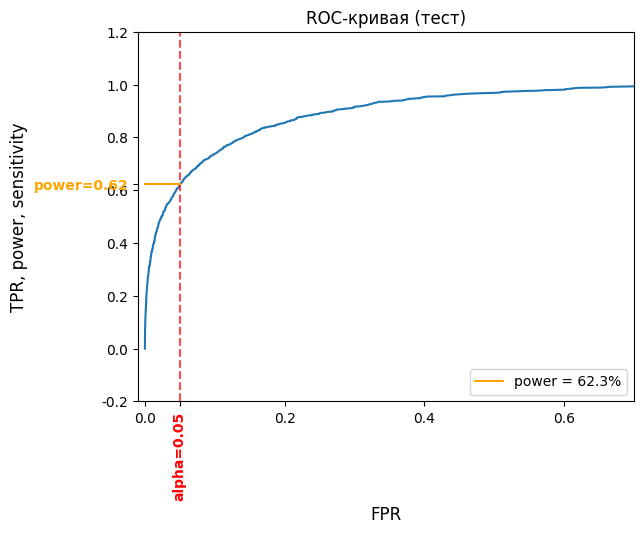

In [30]:
alpha = 0.05
power = np.mean(np.array(pvalues_ab_t) < alpha)

fig, ax = plt.subplots()

ax.plot(np.sort(pvalues_ab_t), [i / N for i in range(N)])
ax.axvline(x=alpha, color='r', linestyle='--', alpha=0.7)
ax.plot([0, alpha], [power, power], color='orange', label=f'power = {(power * 100):.1f}%')
ax.legend(loc='lower right')

current_xticks = list(ax.get_xticks())
current_xlabels = [str(round(tick, 1)) for tick in ax.get_xticks()]

if alpha not in current_xticks:
    current_xticks.append(alpha)
    current_xlabels.append(f'alpha={alpha:.2f}')
    ax.set_xticks(current_xticks)
    ax.set_xticklabels(current_xlabels)

for label in ax.get_xticklabels():
    if label.get_text() == f'alpha={alpha:.2f}':
        label.set_color('red')
        label.set_fontweight('bold')
        label.set_rotation(90)

current_yticks = list(ax.get_yticks())
current_ylabels = [str(round(tick, 1)) for tick in ax.get_yticks()]

if power not in current_yticks:
    current_yticks.append(power)
    current_ylabels.append(f'power={power:.2f}')
    ax.set_yticks(current_yticks)
    ax.set_yticklabels(current_ylabels)

for label in ax.get_yticklabels():
    if label.get_text() == f'power={power:.2f}':
        label.set_color('orange')
        label.set_fontweight('bold')

plt.xlim(-0.01, 0.7)
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR, power, sensitivity', fontsize=12)
plt.title(f'ROC-кривая (тест)', fontsize=12)
plt.show()

#### Полученная ROC-кривая имеет выпуклую форму, однако мощность теста составила ~60%, что меньше общепринятого порога в 80%. Это говорит о **недостаточной чувствительности** проведенного A/B-теста. Это означает, что при условии, что наблюдаемый эффект (разница в долях) соответствует реальному, данный тестовый дизайн (с текущими объемами выборок и уровнем вариативности) позволил бы корректно обнаружить эффект только в 60% случаев повторения эксперимента. 
#### В целом, это был ожидаемый результат, так как из-за пересекающихся выборок нам пришлось проанализировать только 25% займов. И хотя мы получили p-value < alpha (0.02 < 0.05), доверять этому результату нужно меньше, чем если бы мощность была бы 80-90%. Риск того, что это статистическая флуктуация, выше. Это является аргументом в пользу перезапуска теста с корректной выборкой, чтобы повысить мощность и, как следствие, надежность.  
#### Так как по анализируемым займам у нас имеются данные от 25.10, то можно использовать флаг оплаты 25.10 как ковариату для метода CUPED, что может повысить чувствительность теста при условии корреляции между целевым признаком и ковариатой.

#### _5. Определим корреляцию между флагами оплаты в претесте и тесте._

In [32]:
np.corrcoef(df_itog['payment_flag_pre'], df_itog['payment_flag_post'])[0, 1]

np.float64(0.048389197238625)

#### Коэф-т корреляции близок к нулю, что говорит об отсутствии линейной взаимосвязи между ковариатой и целевым признаком. Следовательно, использование CUPED не даст результатов. Проверим это: рассчитаем скорректированный признак для CUPED, проведем t-тесты (на исходной выборке и на выборках Монте-Карло), построим гисторгамму распределения и ROC-кривую.

In [34]:
# Pасчет скорректированного признака для CUPED

covariance = np.cov(df_itog['payment_flag_pre'], df_itog['payment_flag_post'])[0, 1]
variance_pre = np.var(df_itog['payment_flag_pre'])

theta = covariance / variance_pre if variance_pre > 0 else 0
mean_pre = df_itog['payment_flag_pre'].mean()

df_itog['post_adjusted'] = df_itog['payment_flag_post'] - theta * (df_itog['payment_flag_pre'] - mean_pre)

control_adj = df_itog[df_itog['treatment_flag'] == 0]['post_adjusted']
test_adj = df_itog[df_itog['treatment_flag'] == 1]['post_adjusted']

print('CUPED')
print(f'Конверсия Контрольная гр.: {control_adj.mean():.3f}\nКонверсия Тестовая гр.: {test_adj.mean():.3f}')

CUPED
Конверсия Контрольная гр.: 0.037
Конверсия Тестовая гр.: 0.043


In [35]:
# t-test для проверки гипотезу о равенстве средних (с правосторонней альтернативой)

p_cuped = ttest_ind(test_adj, control_adj, alternative='larger')[1]
p_cuped

np.float64(0.02194540260110352)

In [36]:
# Метод Монте-Карло
N = 1000

pvalues = []
for _ in range(N):
    test = test_adj.sample(len(test_adj), replace=True)
    control = control_adj.sample(len(control_adj), replace=True)
    res = ttest_ind(test, control, alternative='larger')
    pvalues.append(res[1])

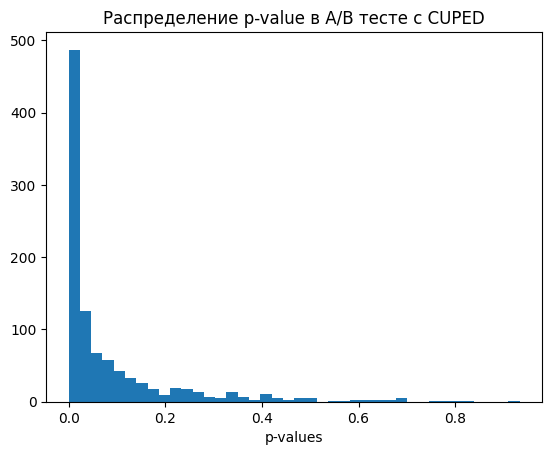

In [37]:
plt.hist(pvalues, bins=40)
plt.xlabel('p-values')
plt.title('Распределение p-value в A/B тесте c CUPED', fontsize=12)
plt.show()

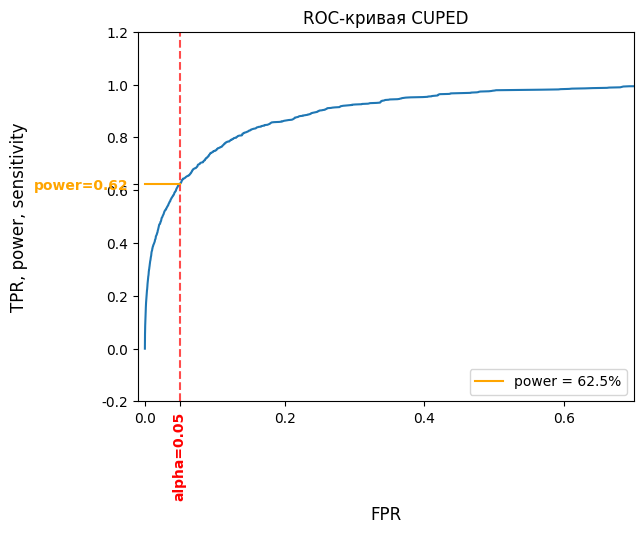

In [41]:
alpha = 0.05
power = np.mean(np.array(pvalues) < alpha)

fig, ax = plt.subplots()

ax.plot(np.sort(pvalues), [i / N for i in range(N)])
ax.axvline(x=alpha, color='r', linestyle='--', alpha=0.7)
ax.plot([0, alpha], [power, power], color='orange', label=f'power = {(power * 100):.1f}%')
ax.legend(loc='lower right')

current_xticks = list(ax.get_xticks())
current_xlabels = [str(round(tick, 1)) for tick in ax.get_xticks()]

if alpha not in current_xticks:
    current_xticks.append(alpha)
    current_xlabels.append(f'alpha={alpha:.2f}')
    ax.set_xticks(current_xticks)
    ax.set_xticklabels(current_xlabels)

for label in ax.get_xticklabels():
    if label.get_text() == f'alpha={alpha:.2f}':
        label.set_color('red')
        label.set_fontweight('bold')
        label.set_rotation(90)

current_yticks = list(ax.get_yticks())
current_ylabels = [str(round(tick, 1)) for tick in ax.get_yticks()]

if power not in current_yticks:
    current_yticks.append(power)
    current_ylabels.append(f'power={power:.2f}')
    ax.set_yticks(current_yticks)
    ax.set_yticklabels(current_ylabels)

for label in ax.get_yticklabels():
    if label.get_text() == f'power={power:.2f}':
        label.set_color('orange')
        label.set_fontweight('bold')

plt.xlim(-0.01, 0.7)
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR, power, sensitivity', fontsize=12)
plt.title(f'ROC-кривая CUPED', fontsize=12)
plt.show()

#### __Основные выводы:__
1. Частичное пересечение выборок (возможно из-за незапланированного сплита, технической ошибки) привело к фактическому уменьшению размера выборки (до 25% от исходного объема).

2. На основании проведенного z-теста на равенство пропорций с правосторонней альтернативой мы отвергаем нулевую гипотезу об отсутствии положительного эффекта. Разница в конверсиях между тестовой и контрольной группами является статистически значимой (p-value ≈ 0.02 при уровне значимости alpha = 0.05). Это указывает на наличие положительного эффекта от внедренного изменения.

3. Величина наблюдаемого эффекта в абсолютном приросте конверсии составила +0.63 п.п. (**uplift**), а в относительном приросте (**lift**) +17.1%, что можно считать значимым с точки зрения бизнеса. При средней сумме платежей, поступившей в течение 3-х дней после взаимодействия, равной 5000 руб. и стоимости отправки смс-сообщения в 3 руб. чистый финансовый эффект от внедрения данной фичи:  
__Чистый финансовый эффект__ = 35 834 (база должников из "изначальной" контрольной группы) * (0.0063 * 5000 - 3) = __1 021 269 руб.__

4. Однако, мощность теста составила всего 62%, что говорит о его невысокой чувствительности и надежности. Результат в 62% означает, что если бы реальный эффект был таким, как мы увидели, то в 62% случаев мы бы его обнаружили, а в 38% случаев — пропустили. Таким образом, к полученному результату нужно относиться с большой осторожностью.  

5. Использование CUPED с ковариатой в виде флага оплаты от 25.10 не дало увеличения мощности, так как корреляция между флагами оплаты в тесте и претесте оказалась близка к нулю. 

####  __Рекомендации:__
1. Не стоит запускать в прод изменения на основе этого теста.
  
2. Так как получившийся эффект является достаточно большим и бизнес-значимым, рекомендуется запустить тест заново. Скорректировать настройки, чтобы избежать пересечений, и заранее рассчитать необходимый размер выборки для мощности 80%+ (с учетом MDE, который важен для бизнеса). Провести тест на чистой, правильно собранной выборке.